In [1]:
import attention_layer
import os
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Flatten, SimpleRNN, GRU
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional, Conv1D, \
    MaxPooling1D, Dropout, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model
from helper.dataset_reader import read_tsv
from helper.utils import *
from callback import get_callbacks

In [2]:
# input data
merged_data = read_tsv('../../../dataset/ijelid-batch-1.tsv')

train_data = read_tsv('../../../dataset/split_batch_1/train.tsv')
val_data = read_tsv('../../../dataset/split_batch_1/val.tsv')
test_data = read_tsv('../../../dataset/split_batch_1/test.tsv')

In [3]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [4]:
df = list_to_dataframe(merged_data)
words = get_unique_words(df)
tags = get_unique_tags(df)

num_words = len(words); print(num_words)
num_tags = len(tags); print(num_tags)
max_len = 100

26890
7


In [5]:
# define the model
def attn_blstm_model(num_words, num_tags, max_len):
    inputs = Input(shape=(max_len,))
    embd_layer = Embedding(input_dim=num_words, output_dim=50, input_length=max_len, mask_zero=True)(inputs)
    blstm_layer = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_activation='sigmoid'))(embd_layer)
    attn_layer = attention_layer.Attention(return_sequences=True)(blstm_layer)
    out = TimeDistributed(Dense(num_tags, activation="softmax"))(attn_layer)
    model = Model(inputs, out)

    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    return model

In [6]:
model = attn_blstm_model(num_words, num_tags, max_len)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1344500   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         58880     
 l)                                                              
                                                                 
 attention (Attention)       (None, 100, 128)          228       
                                                                 
 time_distributed (TimeDistr  (None, 100, 7)           903       
 ibuted)                                                         
                                                                 
Total params: 1,404,511
Trainable params: 1,404,511
Non-train

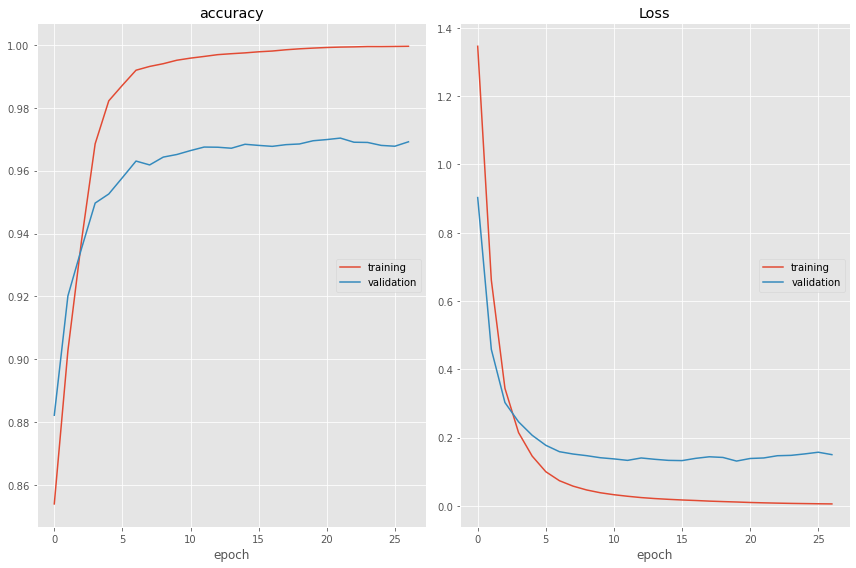

accuracy
	training         	 (min:    0.854, max:    1.000, cur:    1.000)
	validation       	 (min:    0.882, max:    0.970, cur:    0.969)
Loss
	training         	 (min:    0.006, max:    1.346, cur:    0.006)
	validation       	 (min:    0.132, max:    0.903, cur:    0.150)

Epoch 27: val_loss did not improve from 0.13151
56/56 [==============================] - 1s 18ms/step - loss: 0.1516 - accuracy: 0.9704
[0.15156830847263336, 0.9703537225723267]


In [7]:
root_path = 'model/'
model_name = 'attn_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [8]:
len(y_test)

1781

In [9]:
all_w_pair, all_true_pair, all_pred_pair = predict_result(model=model, X_test=X_test, y_test=y_test, words=words, tags=tags)

Cara                          ID        	ID
menghilangkan                 ID        	ID
ovt                           EN        	EN
gimana                        ID        	ID
:D                            O         	O
,                             O         	O
walau                         ID        	ID
udh                           ID        	ID
mule                          ID        	ID
teneg                         ID        	ID
tapi                          ID        	ID
ga                            ID        	ID
teneg                         ID        	ID
lagi                          ID        	ID
jadinya                       ID        	ID
(                             O         	O
harusnya                      ID        	ID
ke                            ID        	ID
priv                          EN        	ID
tapi                          ID        	ID
males                         ID        	ID
switch                        EN        	EN
acc                           EN   

In [10]:
true_flat, pred_flat = flatten_result(all_true_pair=all_true_pair, all_pred_pair=all_pred_pair)

              precision    recall  f1-score   support

          ID     0.9127    0.9349    0.9237     22302
          JV     0.7373    0.9028    0.8117      4908
          EN     0.7842    0.8547    0.8180      5018
   MIX-ID-EN     0.9560    0.8253    0.8858       973
   MIX-ID-JV     0.9703    0.8035    0.8791       285
   MIX-JV-EN     0.9399    0.7906    0.8588       277
           O     0.9434    0.7698    0.8478     10161

    accuracy                         0.8798     43924
   macro avg     0.8920    0.8402    0.8607     43924
weighted avg     0.8870    0.8798    0.8800     43924



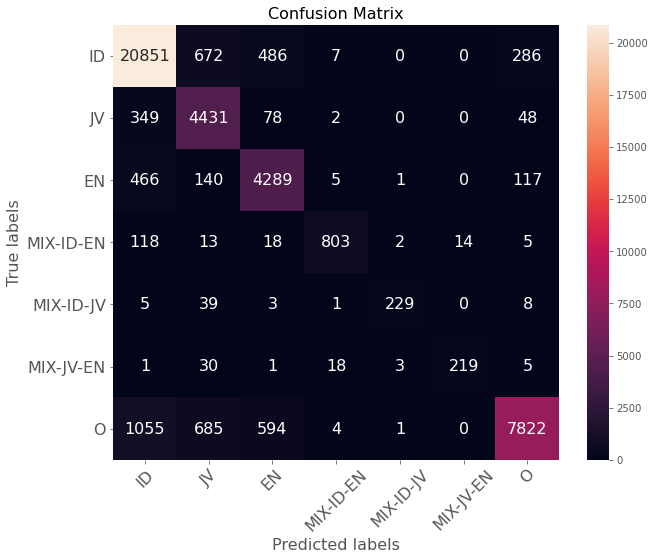

In [11]:
performance_report(true_flat, pred_flat)

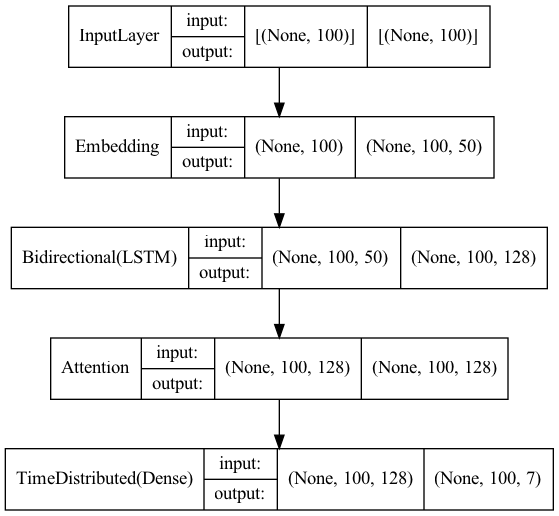

In [12]:
plot_model(model, to_file='model_plot/attention.png', show_shapes=True, show_layer_names=False)